In [ ]:
!git clone https://github.com/gmcheems-org/free-opening-books.git
!pip install chess

Cloning into 'free-opening-books'...
remote: Enumerating objects: 69, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 69 (delta 11), reused 19 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (69/69), 9.07 MiB | 7.57 MiB/s, done.
Resolving deltas: 100% (11/11), done.
Filtering content: 100% (4/4), 148.09 MiB | 32.42 MiB/s, done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 7.3 MB/s eta 0:00:00


In [ ]:
import chess
import random
import time
from IPython.display import display, clear_output

## Chess engine from scratch

In [ ]:
import chess.polyglot


piece_values = {
    chess.PAWN: 100,
    chess.KNIGHT: 320,
    chess.BISHOP: 330,
    chess.ROOK: 500,
    chess.QUEEN: 900,
    chess.KING: 20000
}

def evaluate_board(board, params=None):
    if params is None:
        params = {
            'material_weight': 1.0,
            'pawn_structure_weight': 0.02,
            'king_safety_weight': 0.5,
        }

    evaluation = 0

    material = 0
    psqt = 0

    for piece_type in piece_values:
        material += len(board.pieces(piece_type, chess.WHITE)) * piece_values[piece_type]
        material -= len(board.pieces(piece_type, chess.BLACK)) * piece_values[piece_type]
    evaluation += params['material_weight'] * material
    pawn_structure = 0
    for color in [chess.WHITE, chess.BLACK]:
        pawns = board.pieces(chess.PAWN, color)
        pawn_structure += evaluate_pawn_structure(pawns, color)

    evaluation += params['pawn_structure_weight'] * pawn_structure

    #-1,1
    king_safety = 0
    for color in [chess.WHITE, chess.BLACK]:
        if board.is_check():
            king_safety += 1 if color == chess.WHITE else -1
    evaluation += params['king_safety_weight'] * 10 * king_safety

    return evaluation


def evaluate_pawn_structure(pawns, color):
    score = 0
    file_pawn_count = [0] * 8
    for square in pawns:
        file_pawn_count[chess.square_file(square)] += 1

    # Penalize doubled pawns
    for count in file_pawn_count:
        if count > 1:
            score -= 20 * (count - 1)

    # Penalize isolated pawns
    for file in range(8):
        if file_pawn_count[file] > 0 and (file == 0 or file_pawn_count[file - 1] == 0) and (file == 7 or file_pawn_count[file + 1] == 0):
            score -= 30

    return score if color == chess.WHITE else -score


def minimax(board, depth, alpha, beta, maximizing_player, n_best_moves):
    """Minimax algorithm with alpha-beta pruning and move ordering."""
    if depth == 0 or board.is_game_over():
        return evaluate_board(board)

    legal_moves = list(board.legal_moves)
    move_evaluations = []

    for move in legal_moves:
        board.push(move)
        eval = evaluate_board(board)
        move_evaluations.append((move, eval))
        board.pop()

    move_evaluations.sort(key=lambda x: x[1], reverse=maximizing_player)

    top_moves = move_evaluations[:n_best_moves]

    if maximizing_player:
        max_eval = -10000
        for move, _ in top_moves:
            board.push(move)
            eval = minimax(board, depth - 1, alpha, beta, False, n_best_moves)
            board.pop()
            max_eval = max(max_eval, eval)
            alpha = max(alpha, eval)
            if beta <= alpha:
                break
        return max_eval
    else:
        min_eval = 10000
        for move, _ in top_moves:
            board.push(move)
            eval = minimax(board, depth - 1, alpha, beta, True, n_best_moves)
            board.pop()
            min_eval = min(min_eval, eval)
            beta = min(beta, eval)
            if beta <= alpha:
                break
        return min_eval

def find_best_moves(board, n_best_moves=3, depth=3, maximizing_player=True):
    """Find the best move for a player using a depth-3 search with pruning."""
    best_moves = []
    best_value = float('-inf') if maximizing_player else float('inf')

    with chess.polyglot.open_reader("/content/free-opening-books/books/bin/komodo.bin") as reader:
      try:
        entry = next(reader.find_all(board))
        return [chess.Move.from_uci(f'{entry.move}')]
      except:
        pass


    for move in board.legal_moves:
        board.push(move)
        move_value = minimax(board, depth, -600, 600, not maximizing_player, n_best_moves)
        board.pop()

        if maximizing_player:
            if move_value is not None and move_value > best_value:
                best_value = move_value
                best_moves = [move]
            elif move_value is not None and move_value == best_value:
                best_moves.append(move)
        else:
            if move_value is not None and move_value < best_value:
                best_value = move_value
                best_moves = [move]
            elif move_value is not None and move_value == best_value:
                best_moves.append(move)

    return best_moves

## Engine vs Human

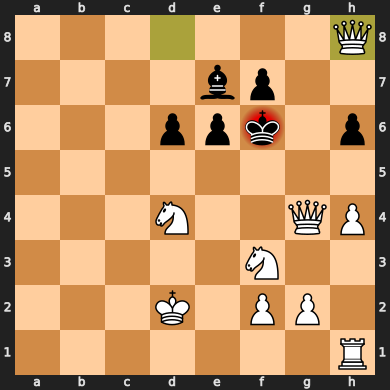

Game over. Result: 1-0


In [ ]:
def play_game():
    """Play a chess game against the engine using find_best_moves."""
    board = chess.Board()

    while not board.is_game_over():
        clear_output(wait=True)
        display(board)

        print("\n" * 5)

        time.sleep(0.2)

        user_move = input("Enter your move (e.g., e2e4): ")


        try:
            move = chess.Move.from_uci(user_move)
            if move in board.legal_moves:
                board.push(move)
            else:
                print("Illegal move. Try again.")
                continue
        except ValueError:
            print("Invalid move format. Use UCI format (e.g., e2e4).")
            continue

        if board.is_game_over():
            break

        clear_output(wait=True)
        display(board)

        engine_move = find_best_moves(board, n_best_moves=18, depth=4, maximizing_player=False)
        if engine_move:
            board.push(engine_move[0])
        else:
            print("No valid moves found by the engine.")
            break

        if board.is_game_over():
            break

    clear_output(wait=True)
    display(board)
    result = board.result()
    print(f"Game over. Result: {result}")

play_game()

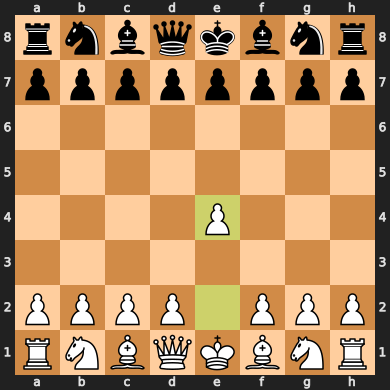

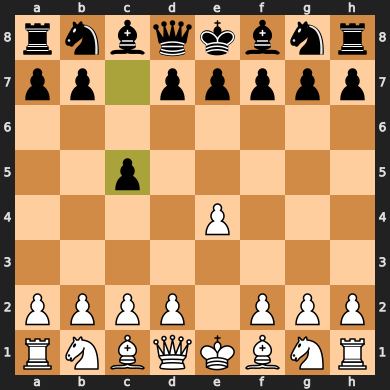

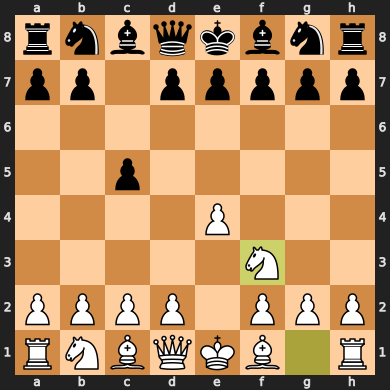

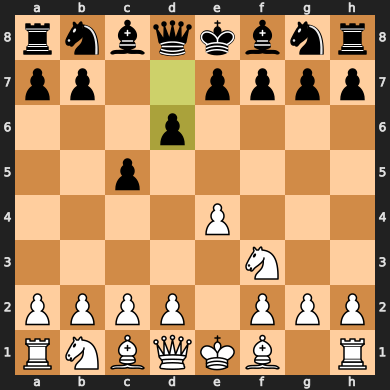

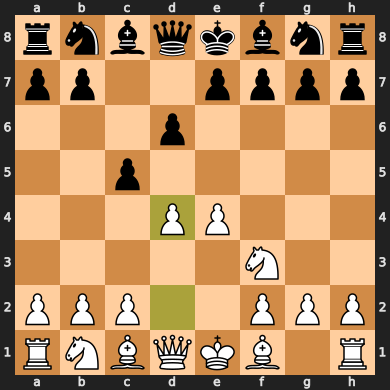

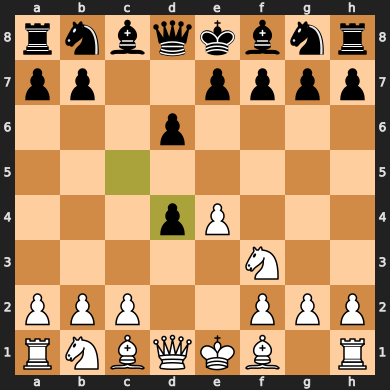

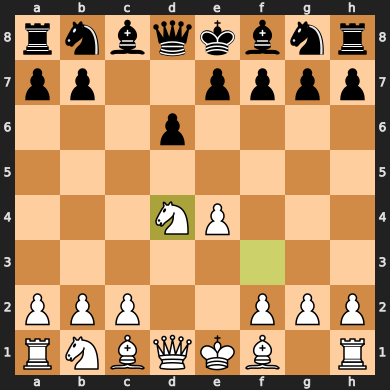

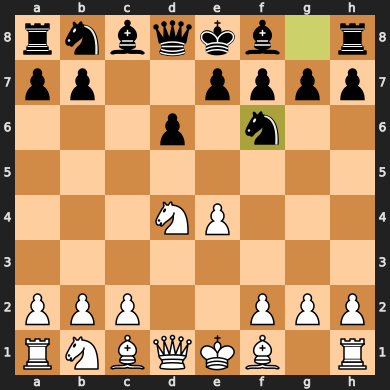

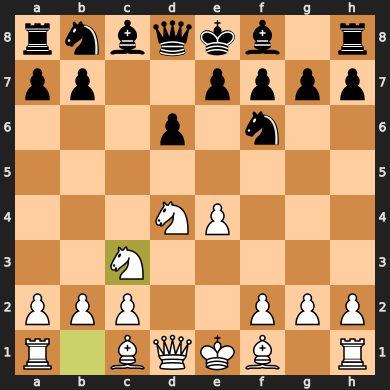

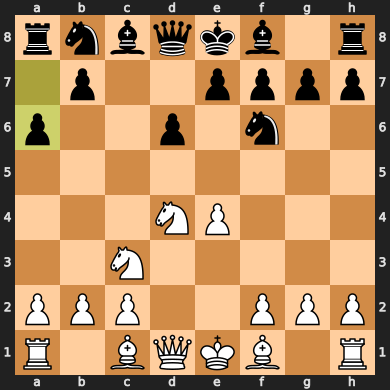

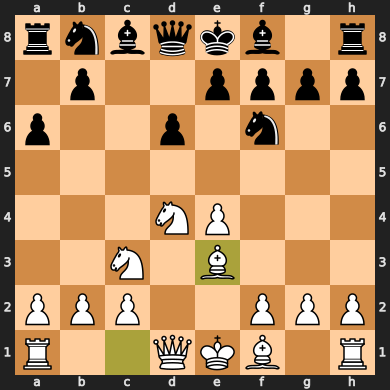

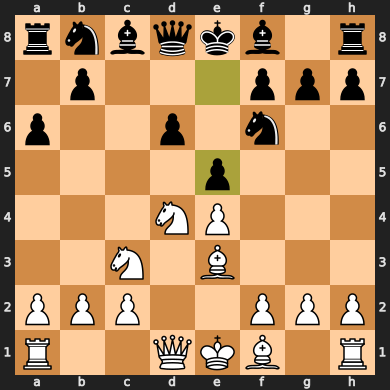

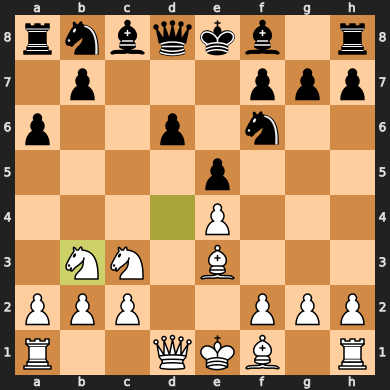

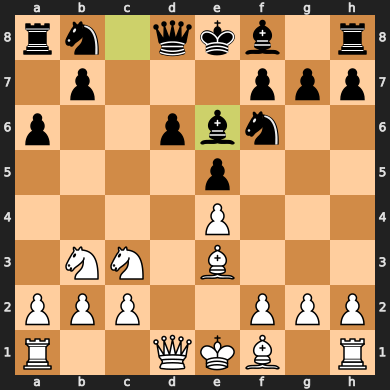

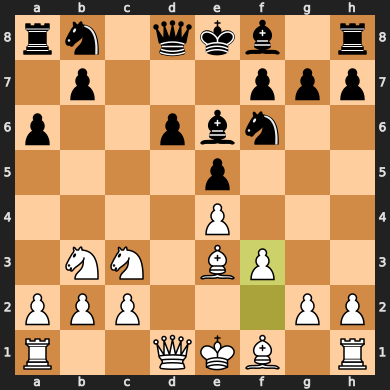

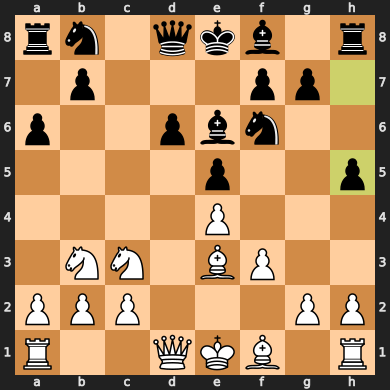

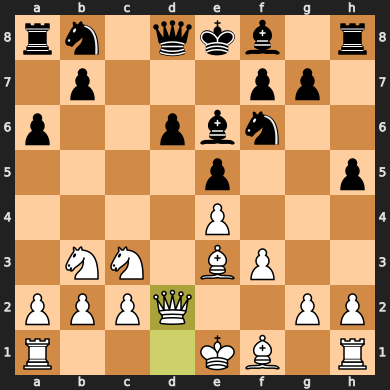

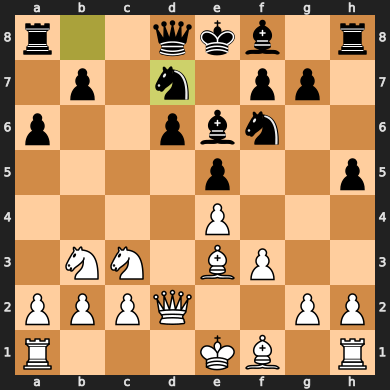

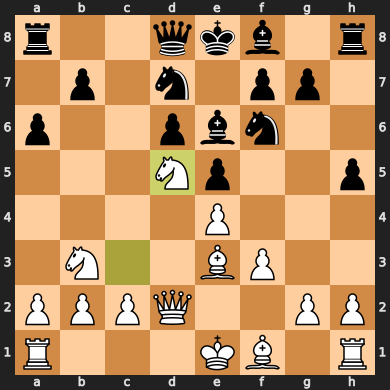

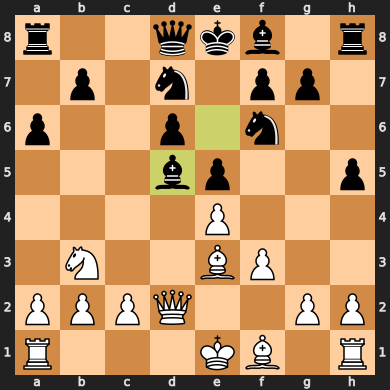

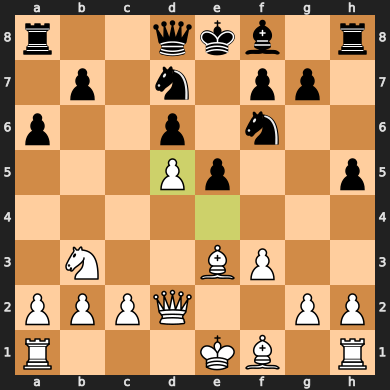

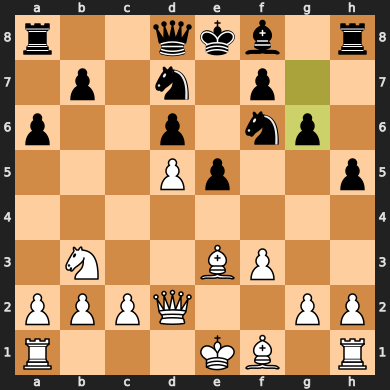

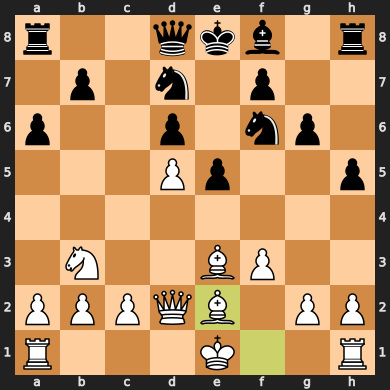

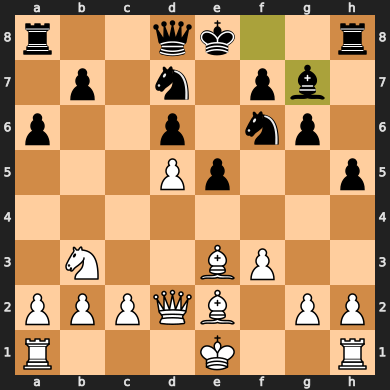

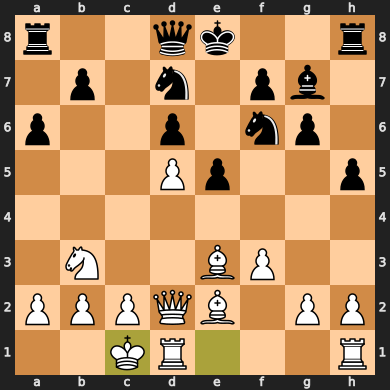

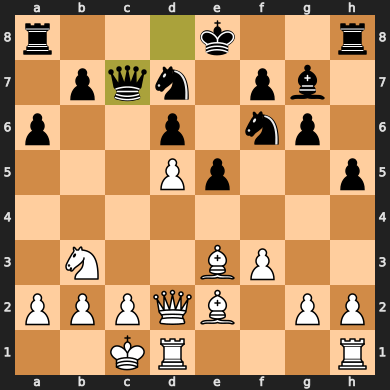

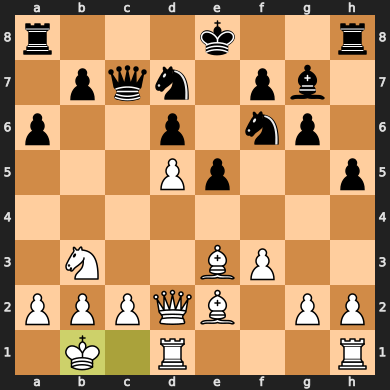

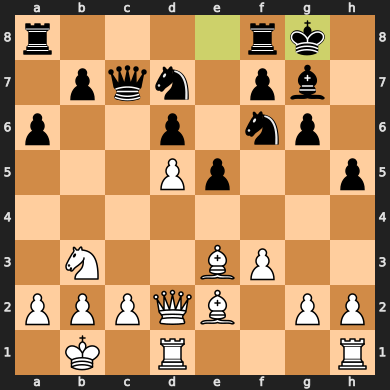

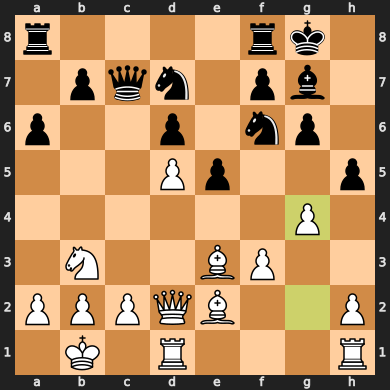

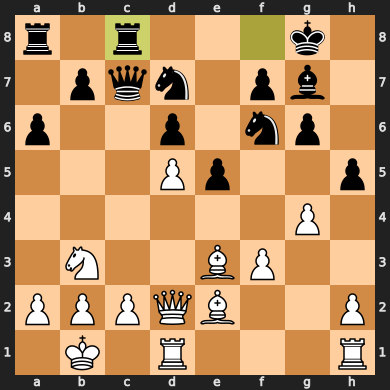

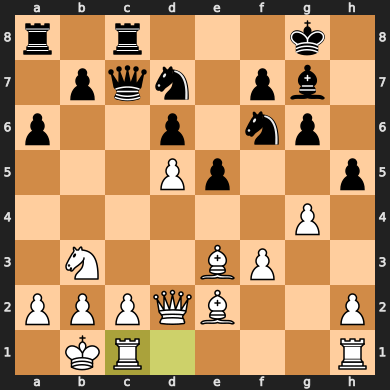

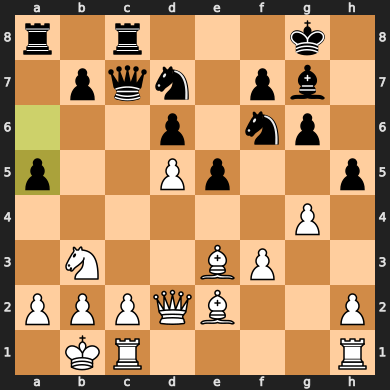

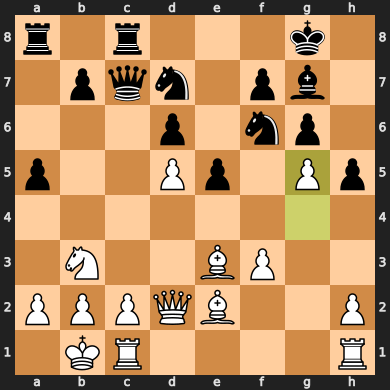

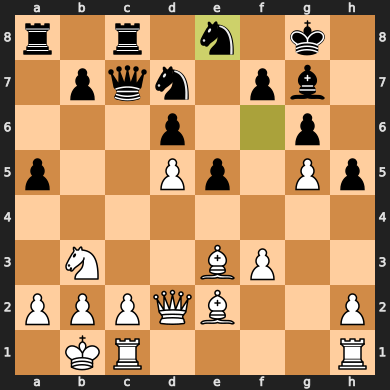

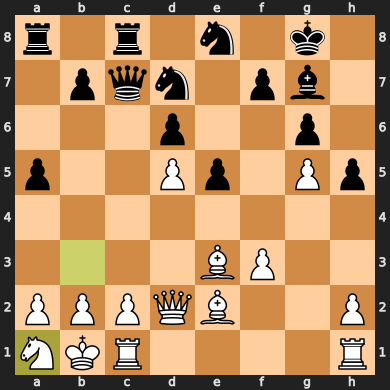

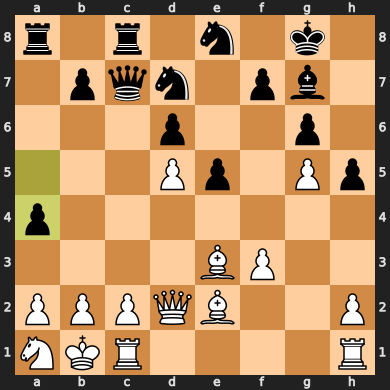

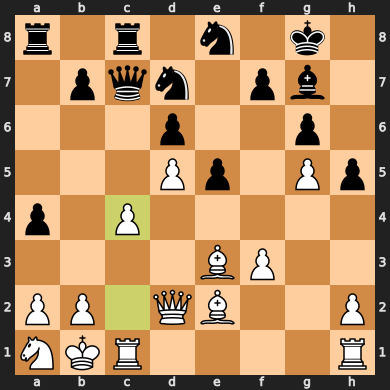

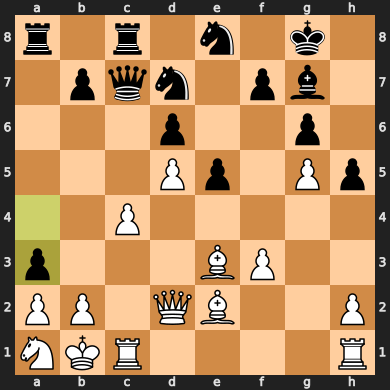

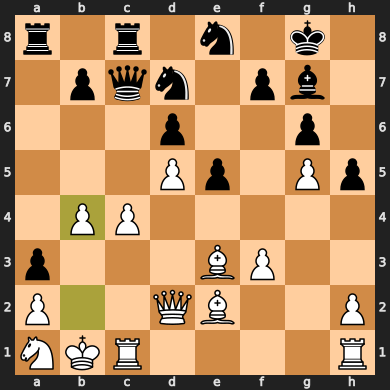

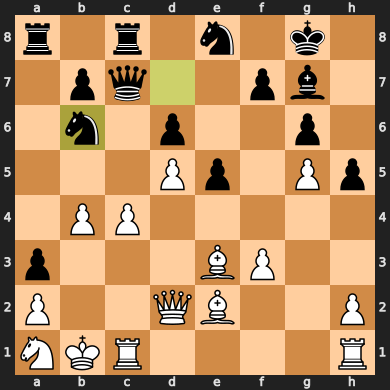

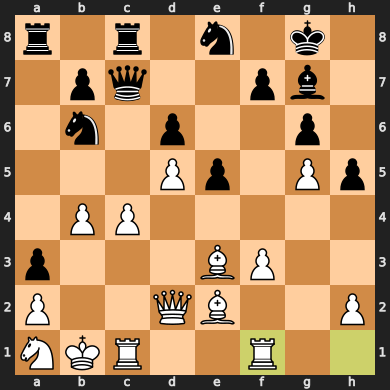

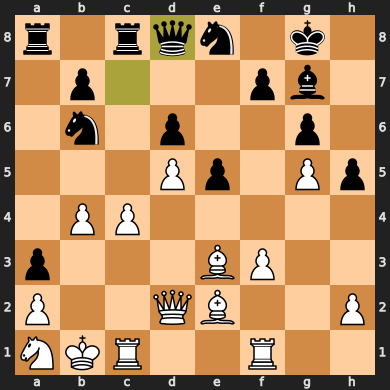

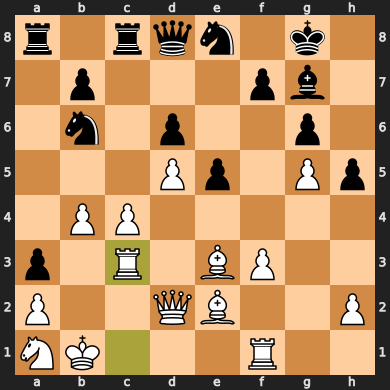

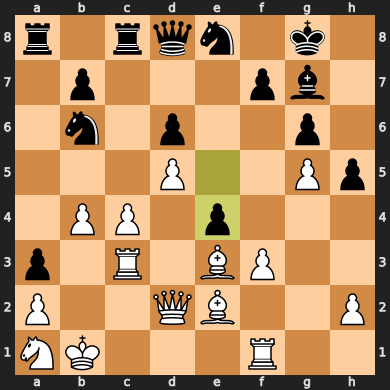

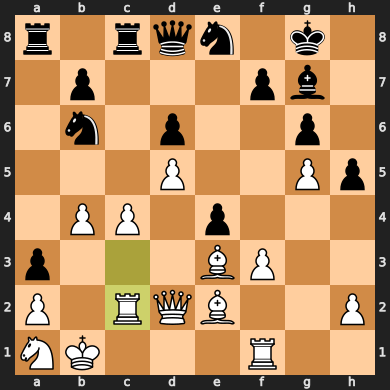

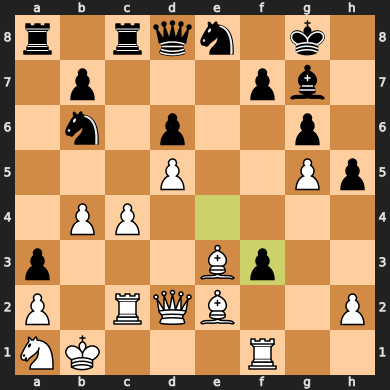

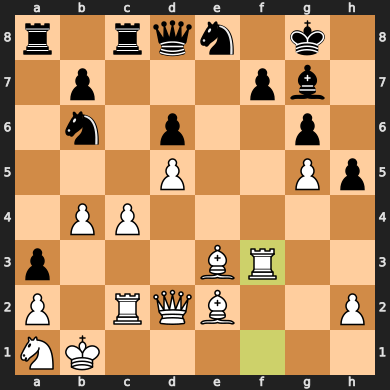

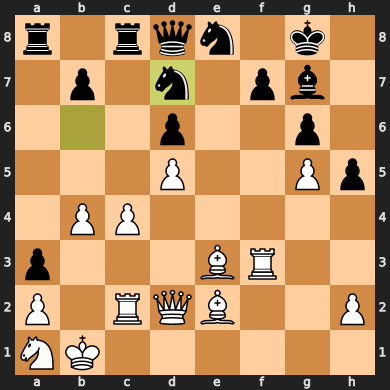

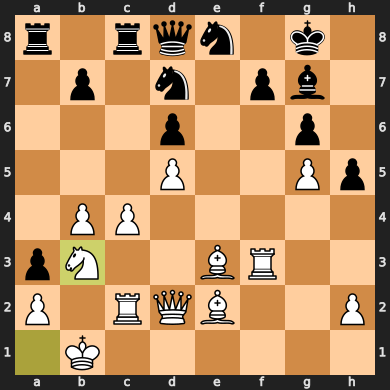

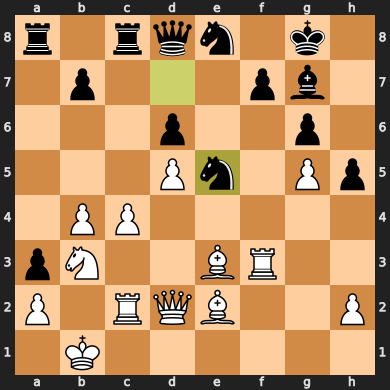

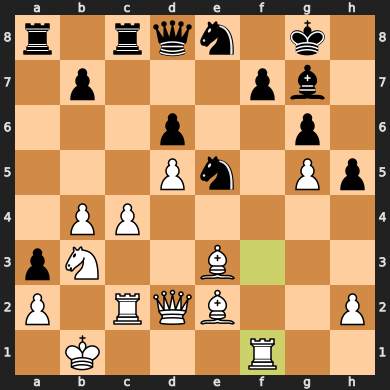

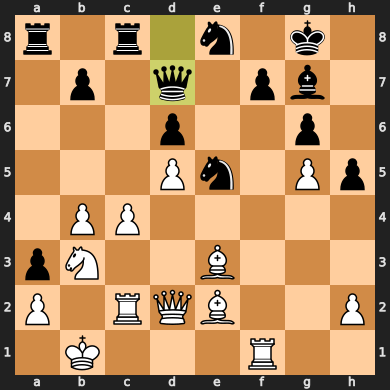

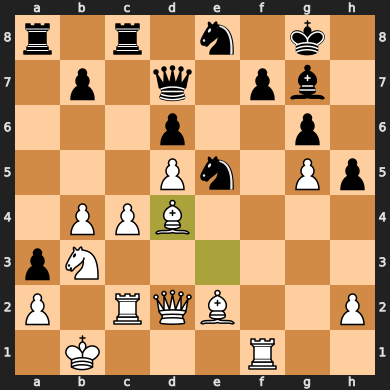

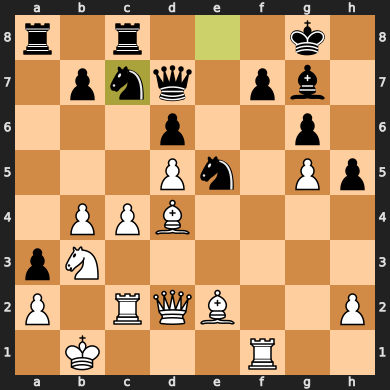

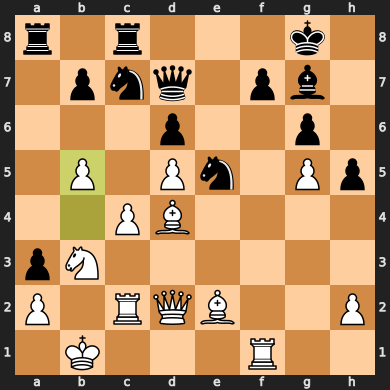

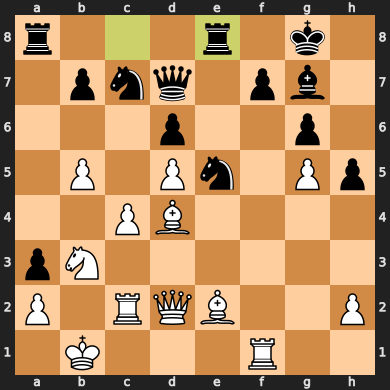

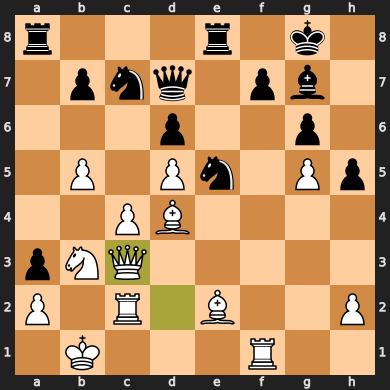

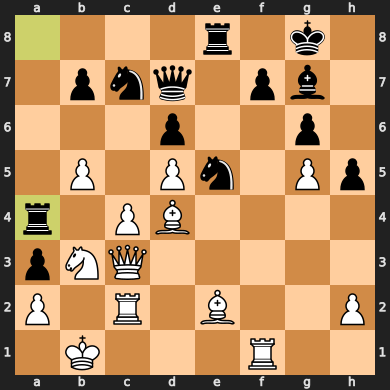

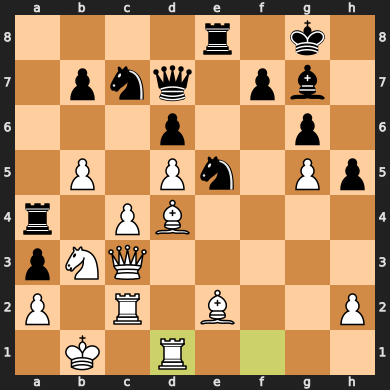

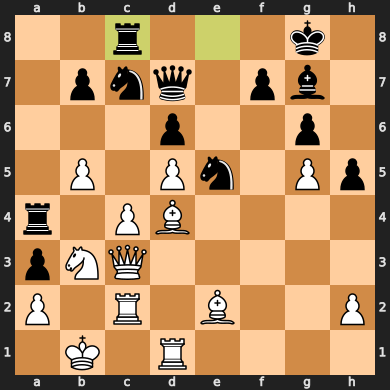

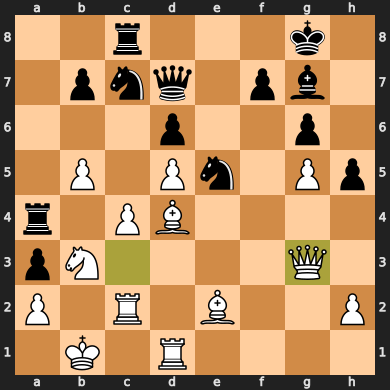

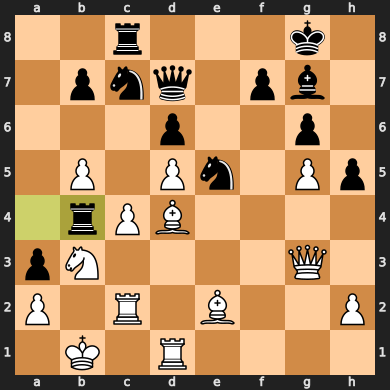

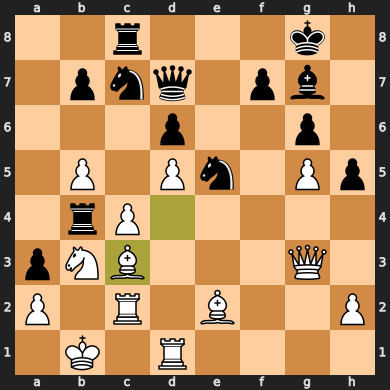

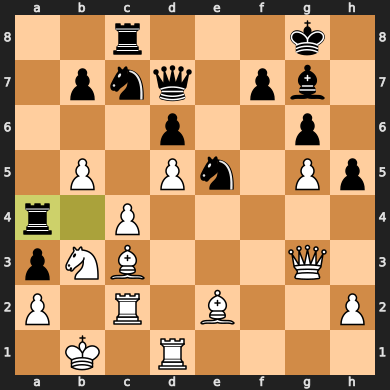

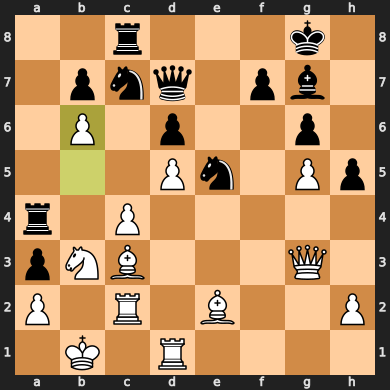

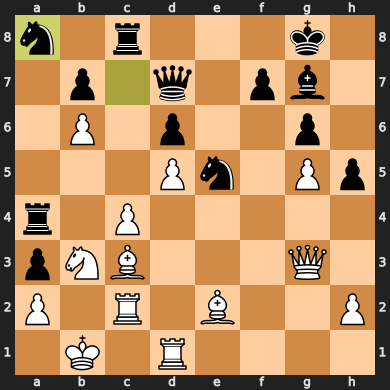

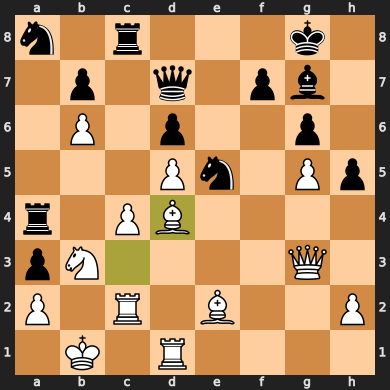

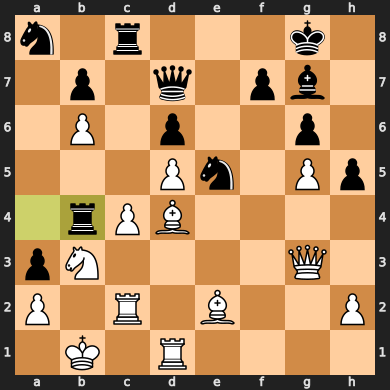

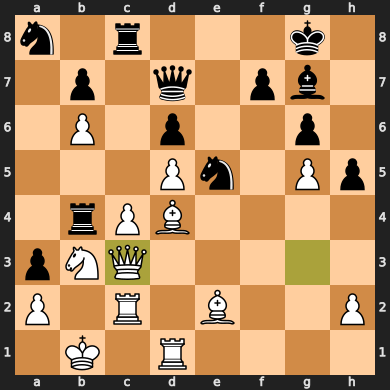

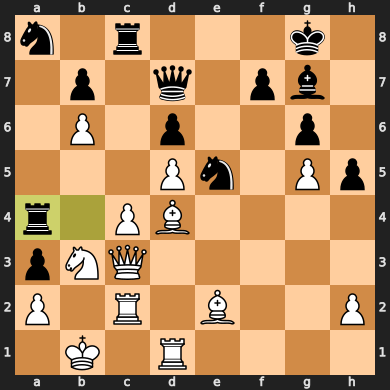

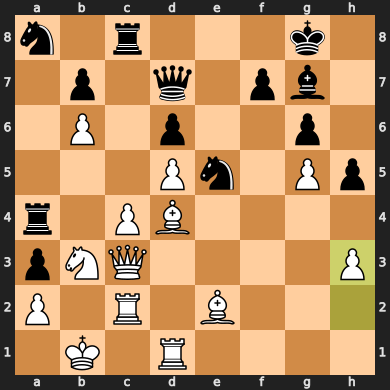

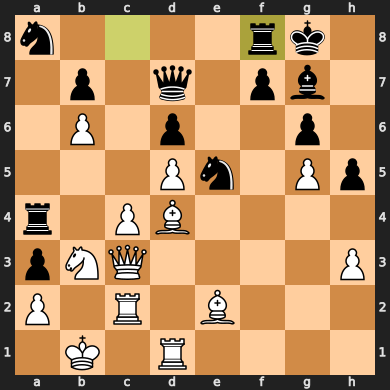

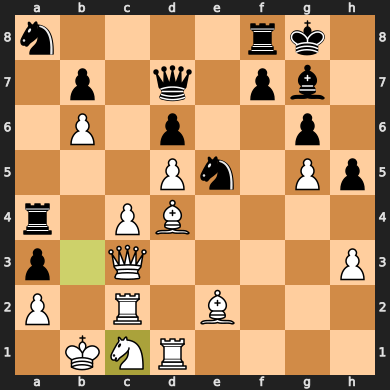

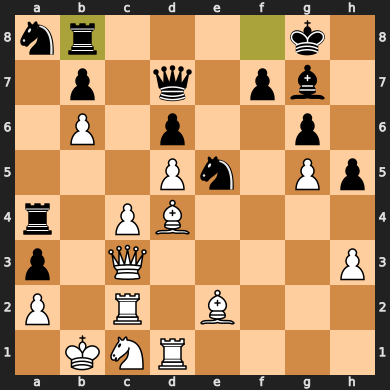

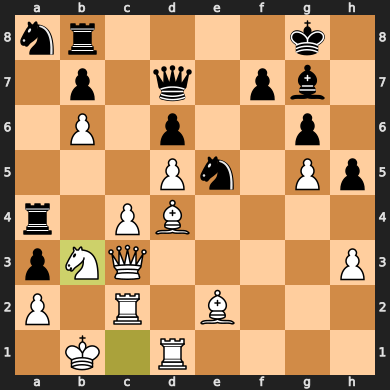

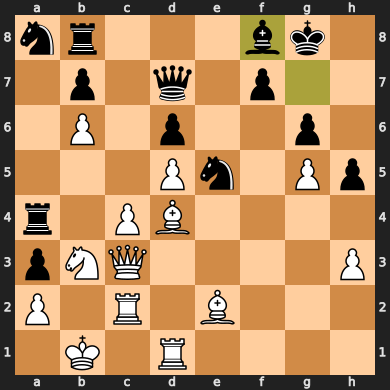

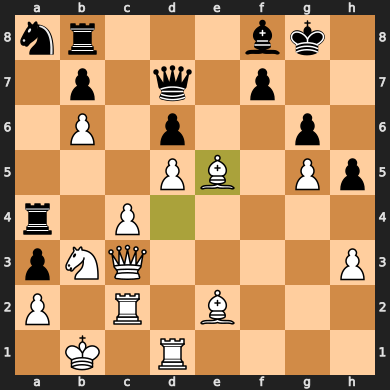

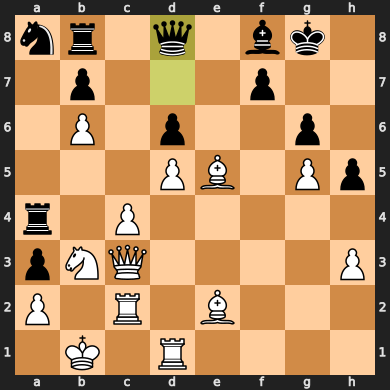

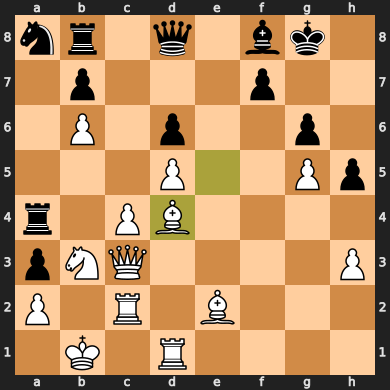

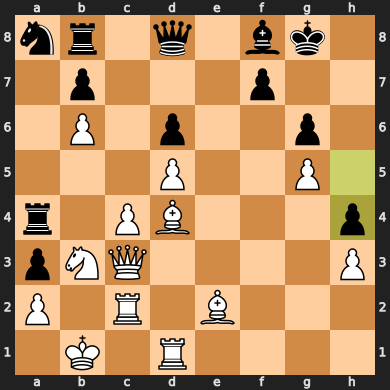

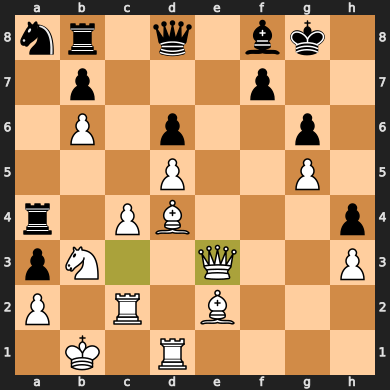

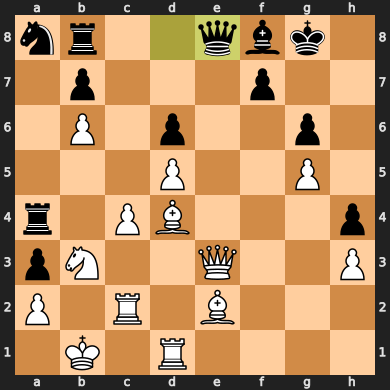

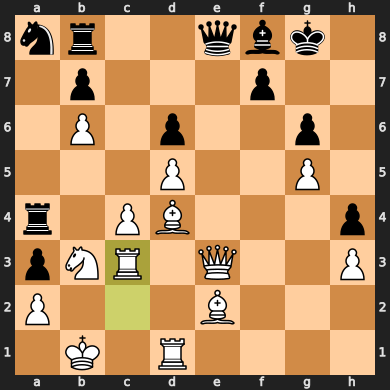

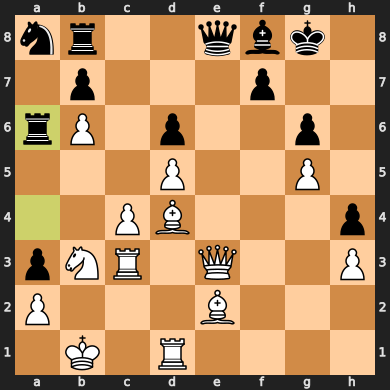

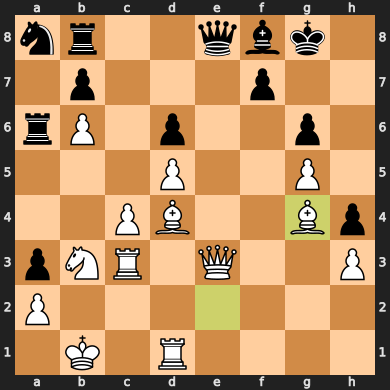

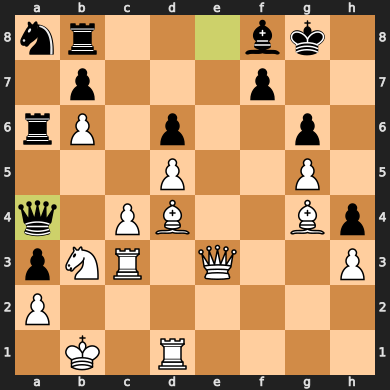

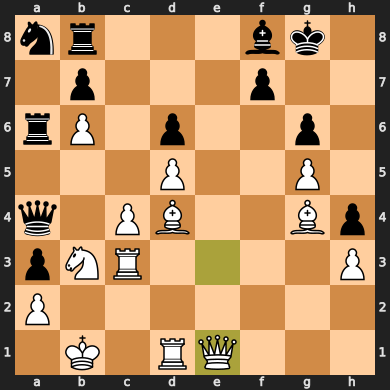

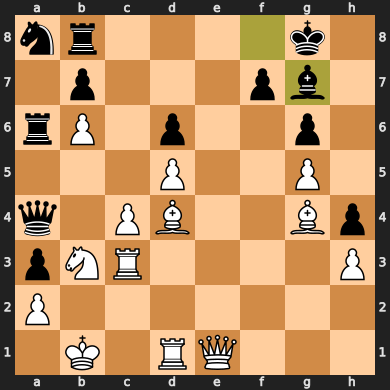

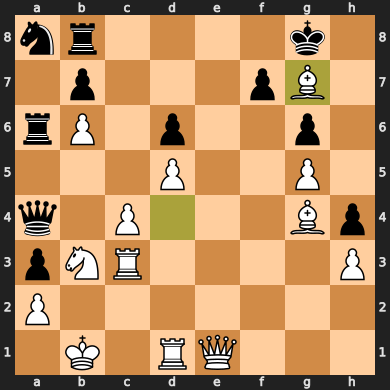

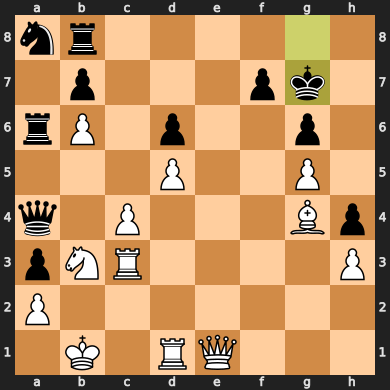

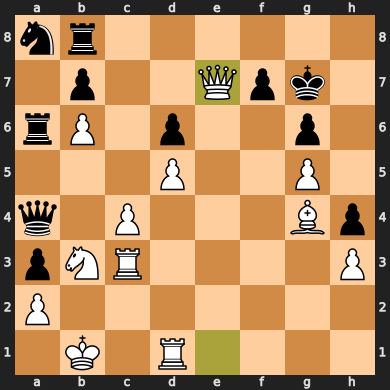

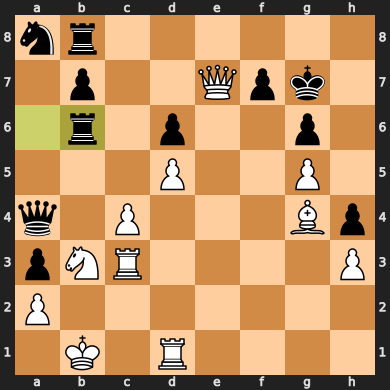

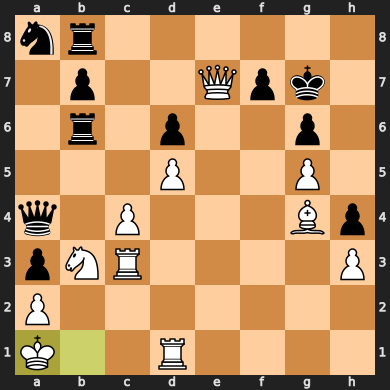

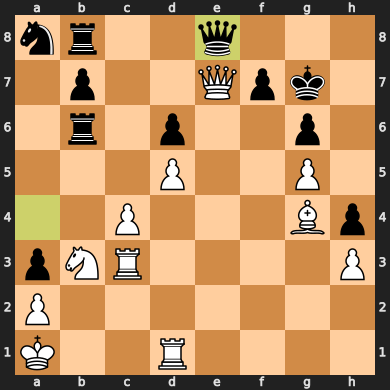

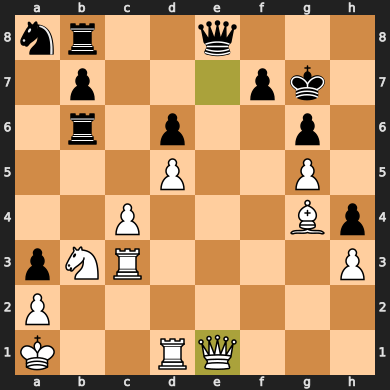

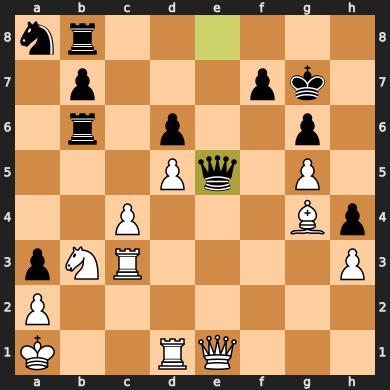

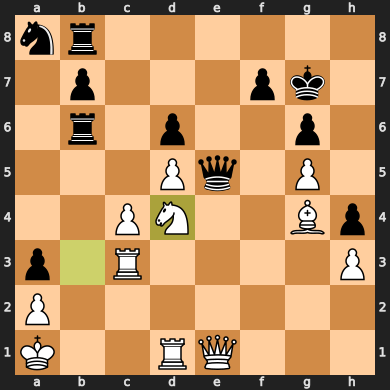

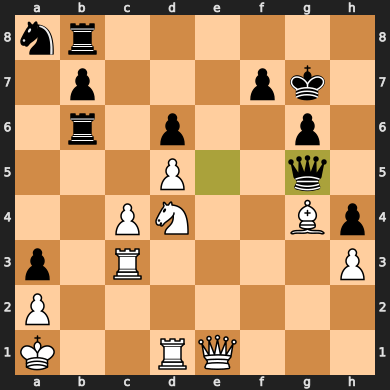

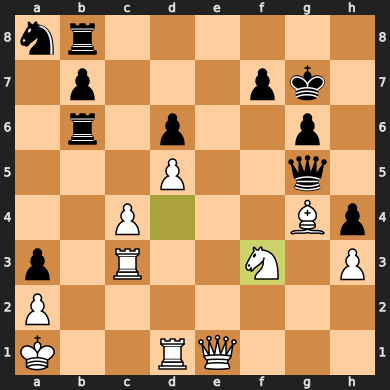

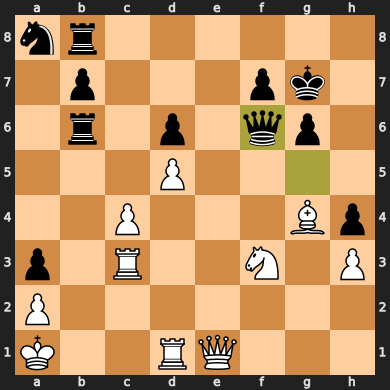

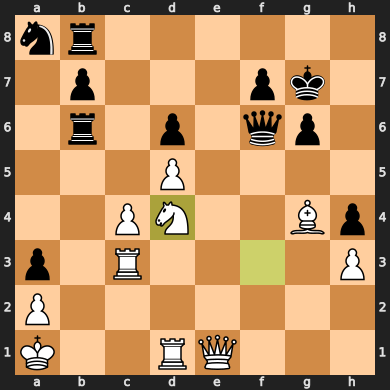

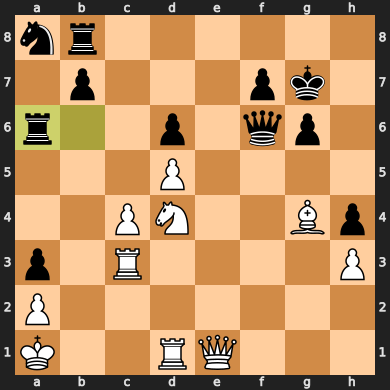

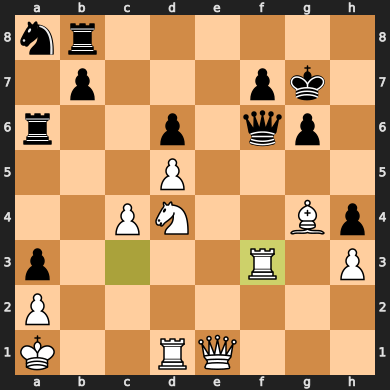

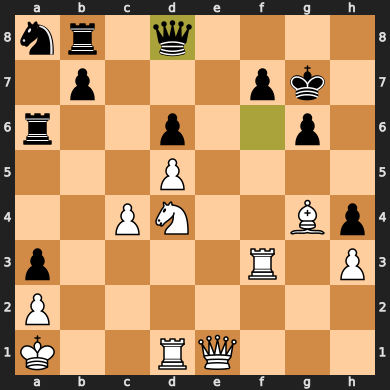

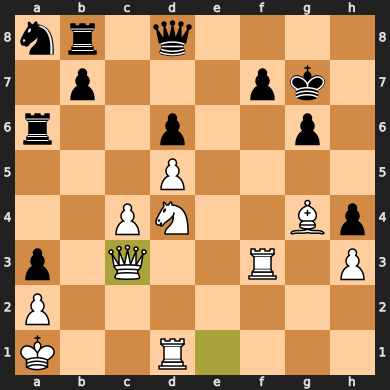

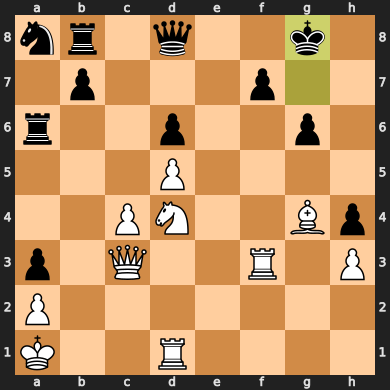

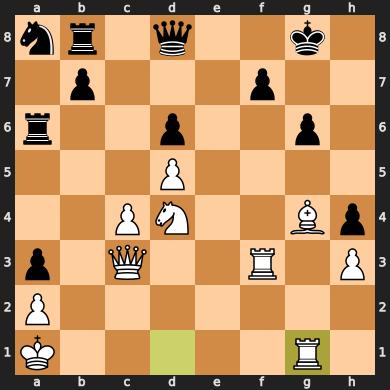

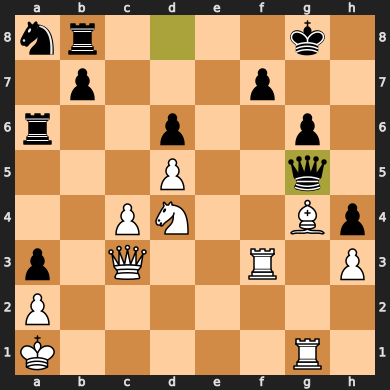

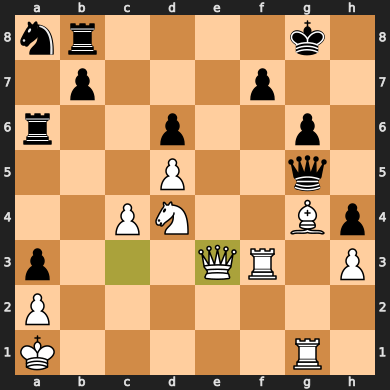

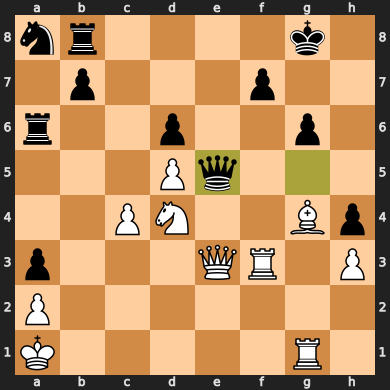

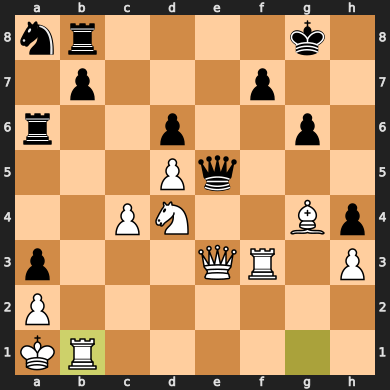

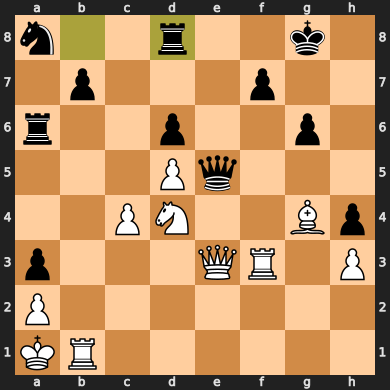

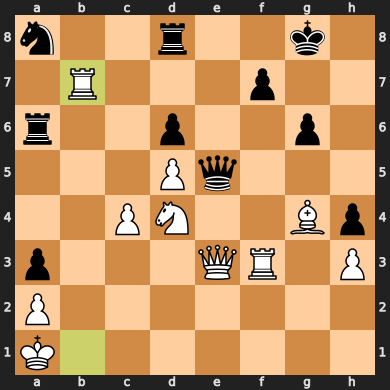

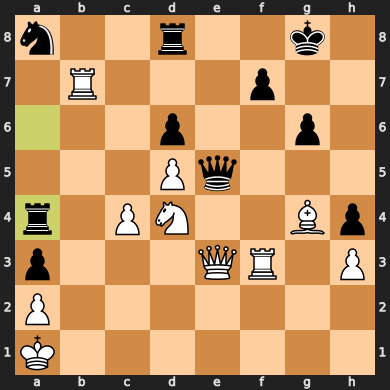

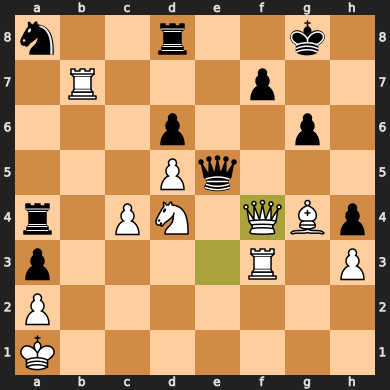

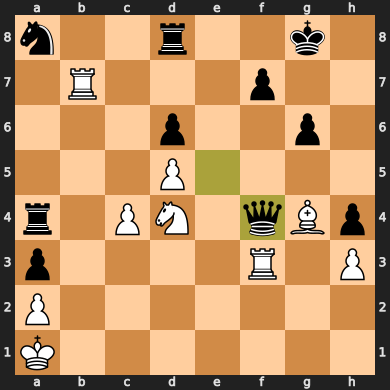

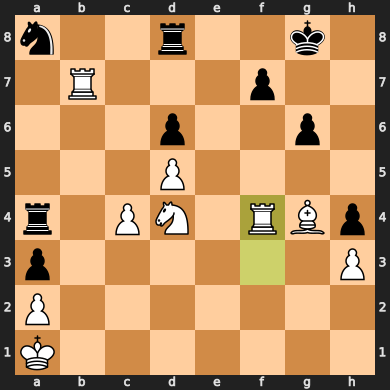

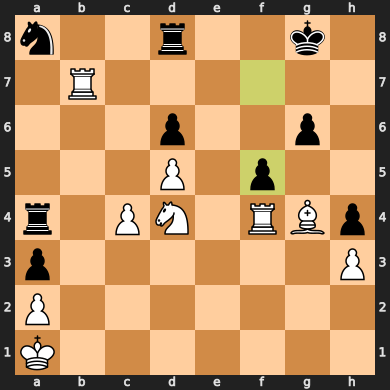

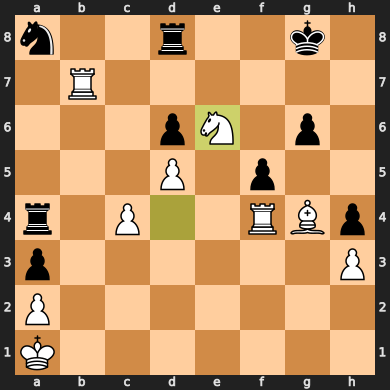

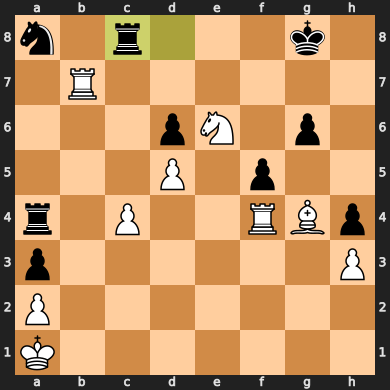

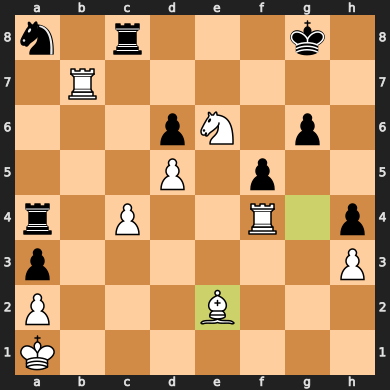

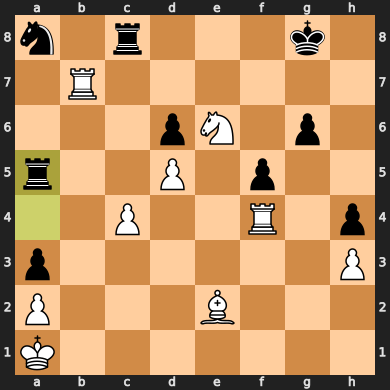

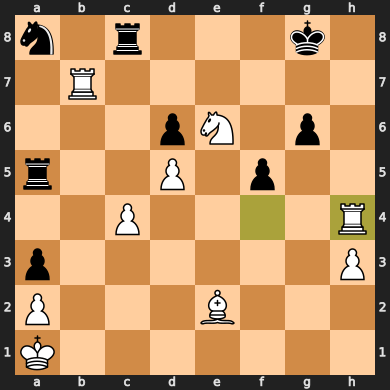

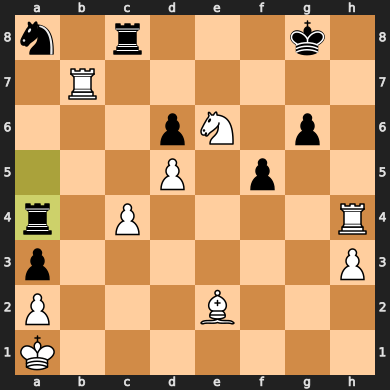

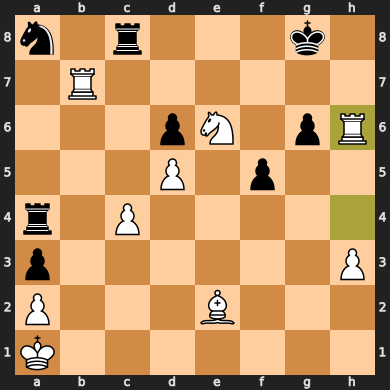

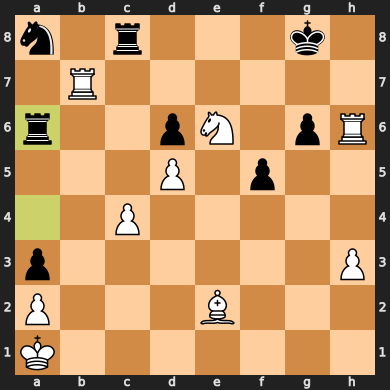

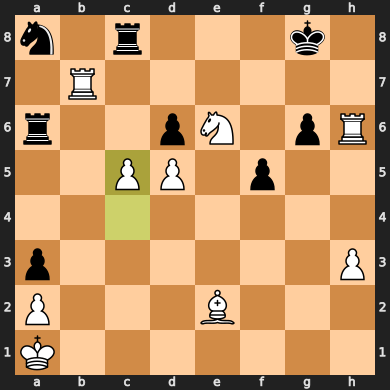

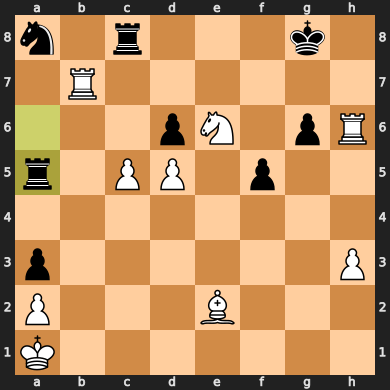

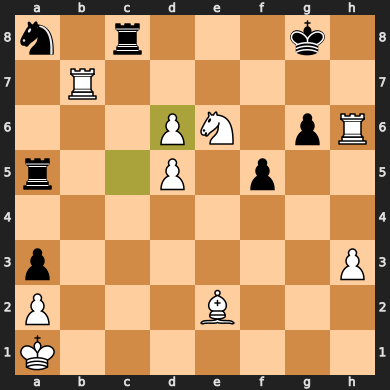

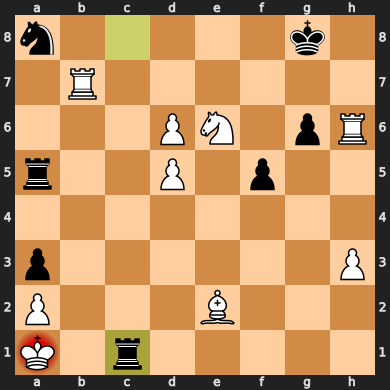

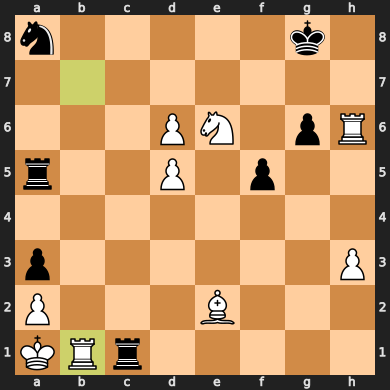

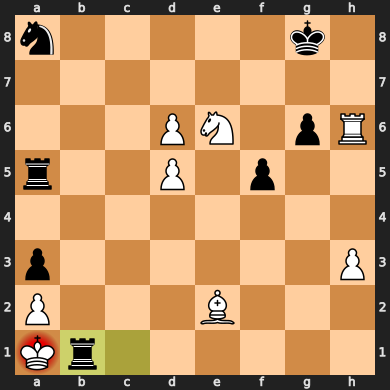

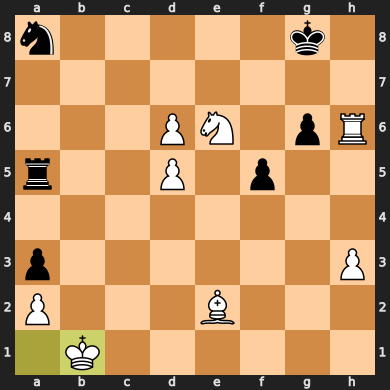

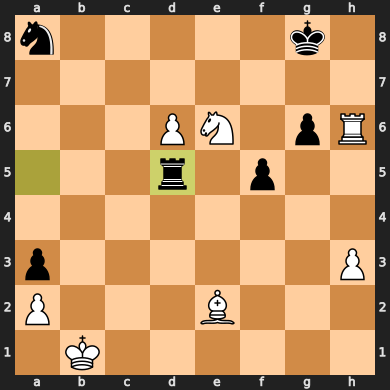

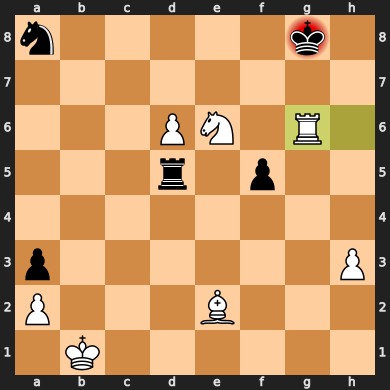

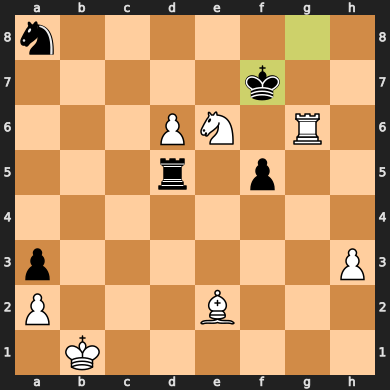

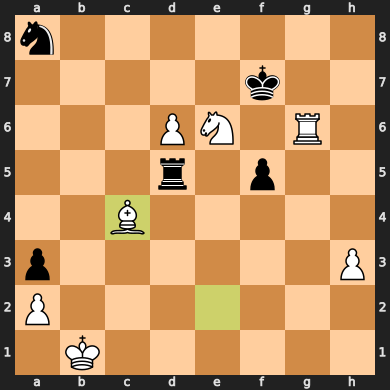

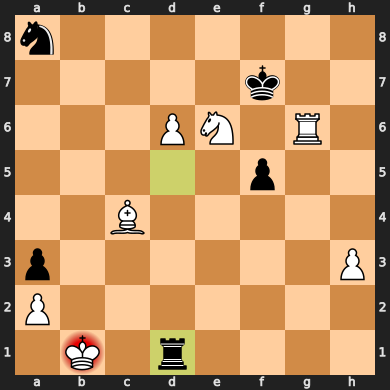

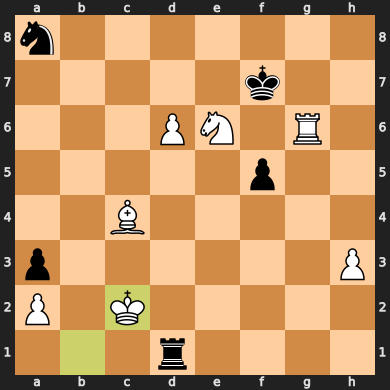

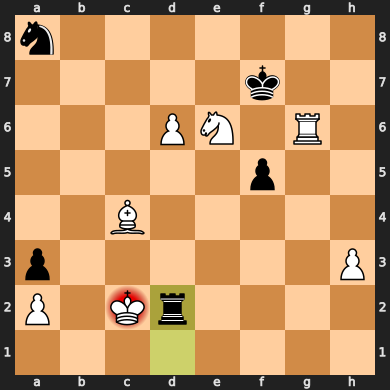

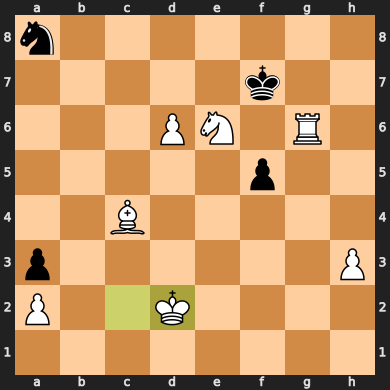

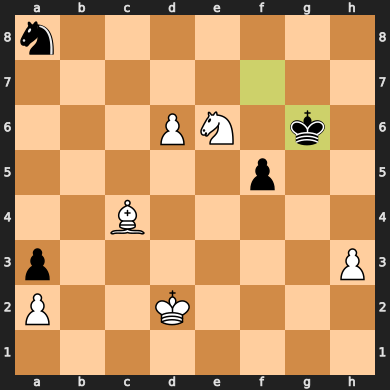

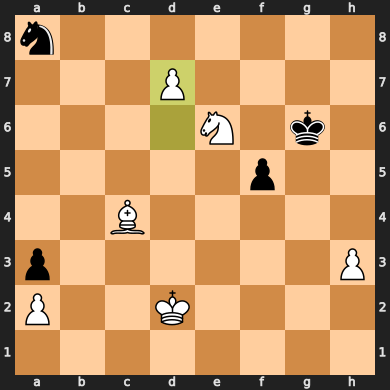

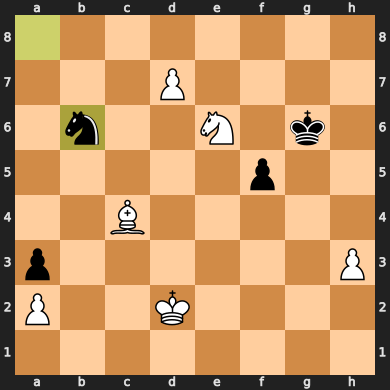

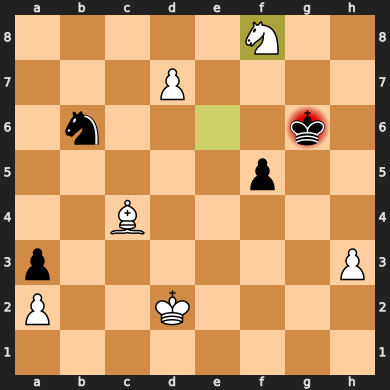

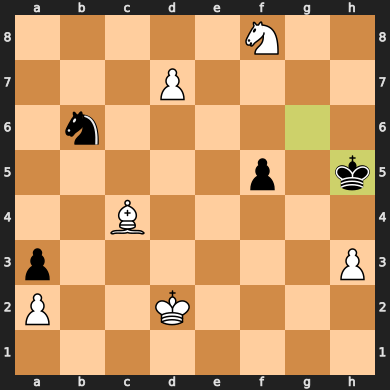

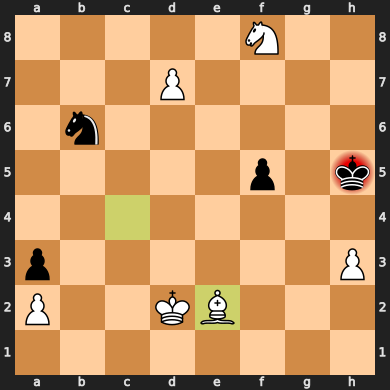

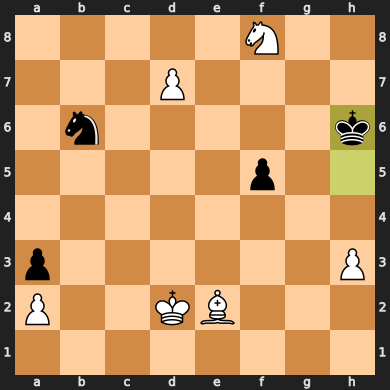

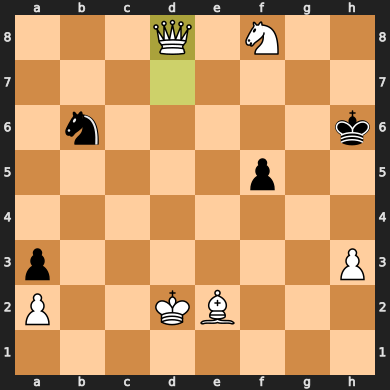

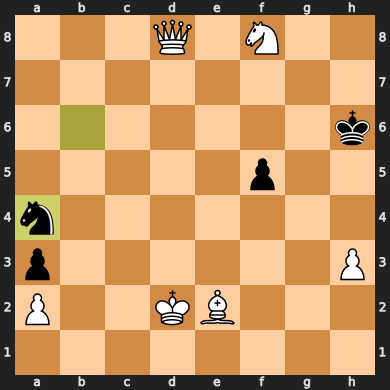

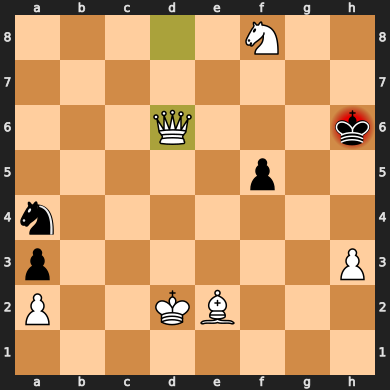

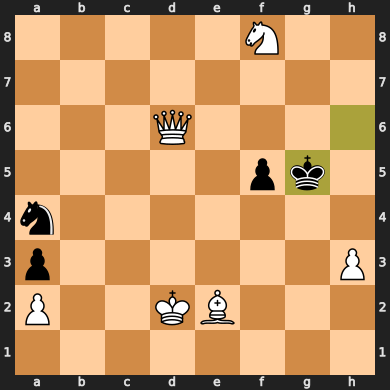

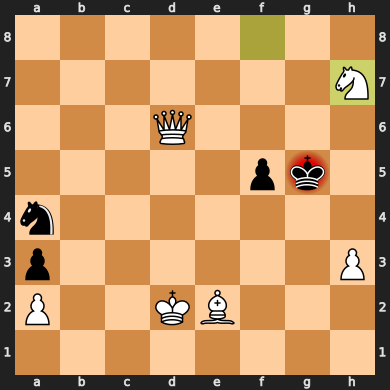

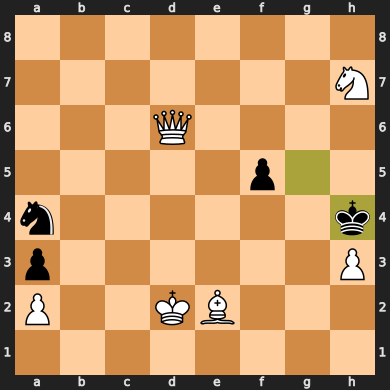

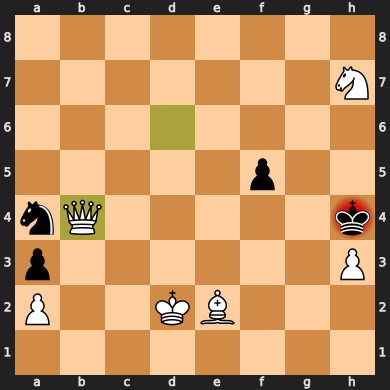

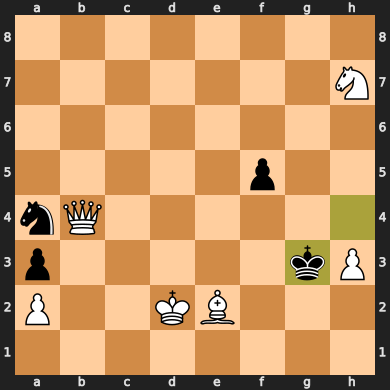

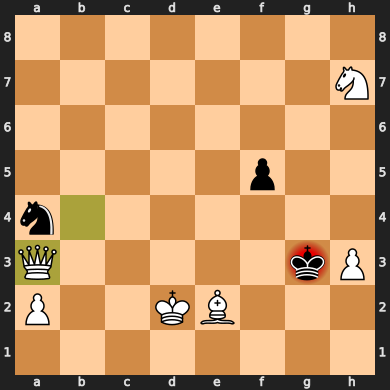

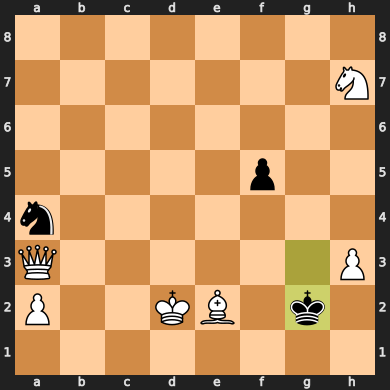

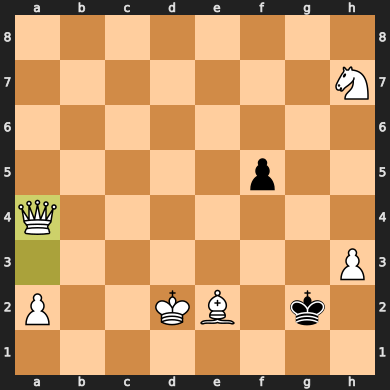

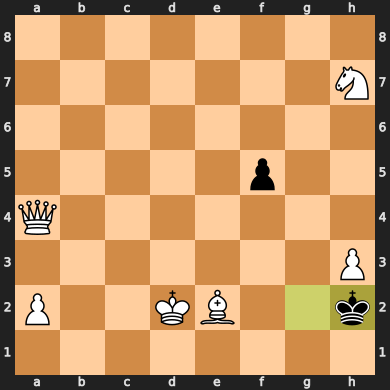

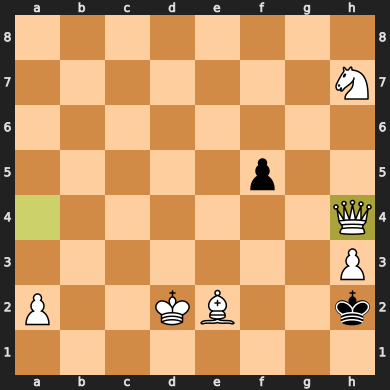

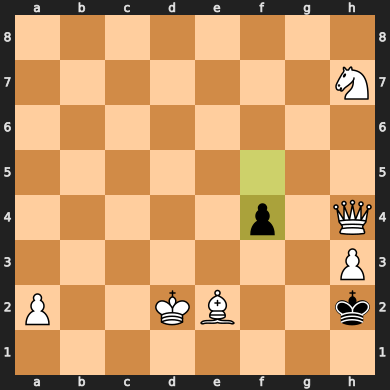

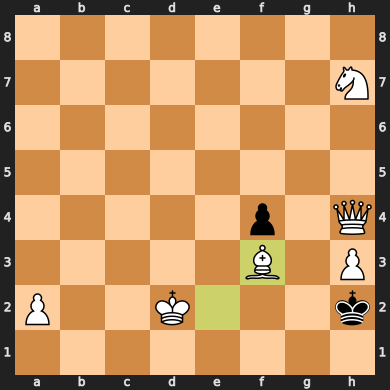

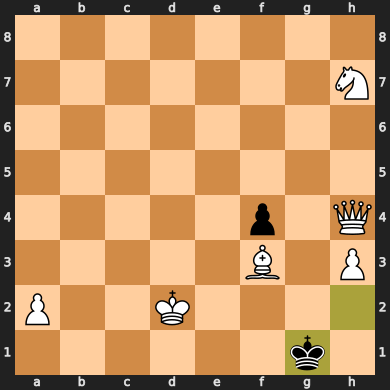

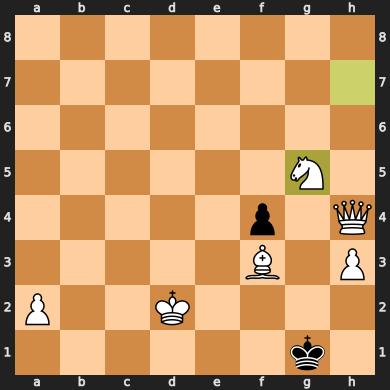

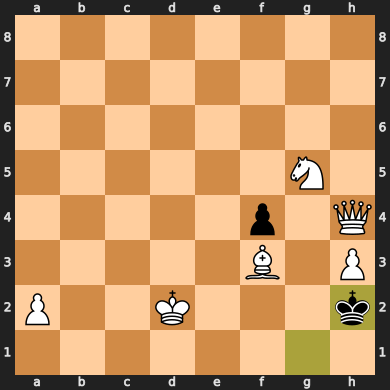

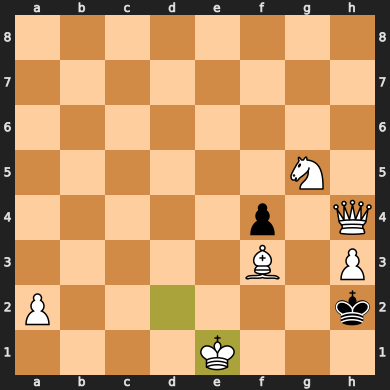

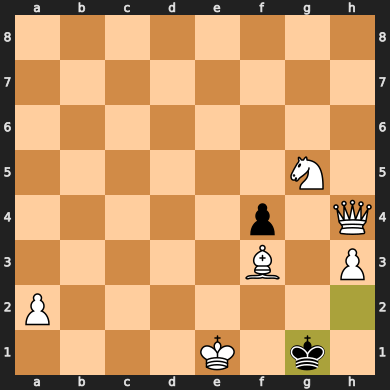

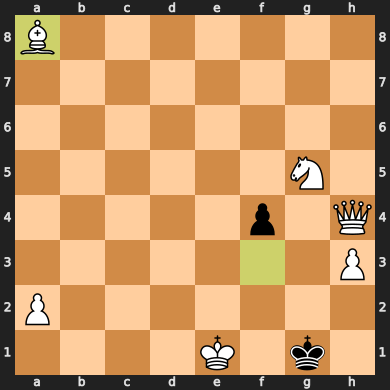

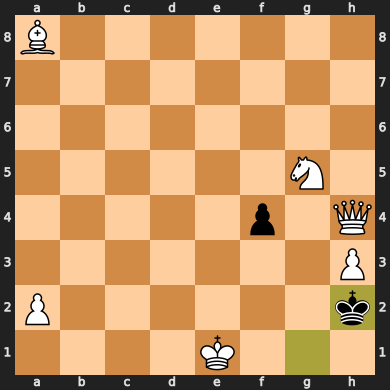

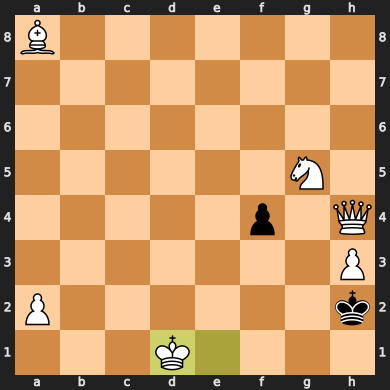

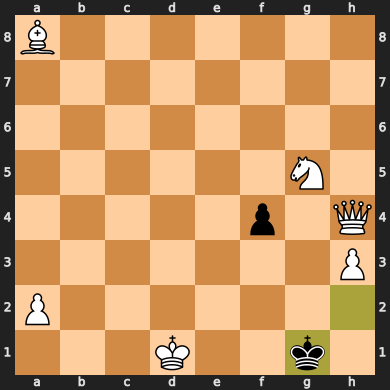

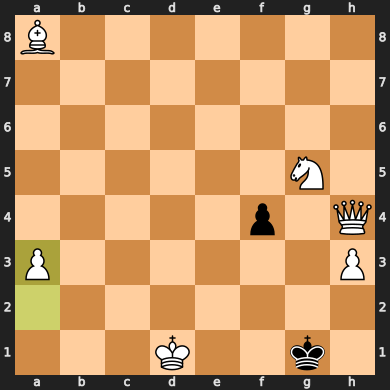

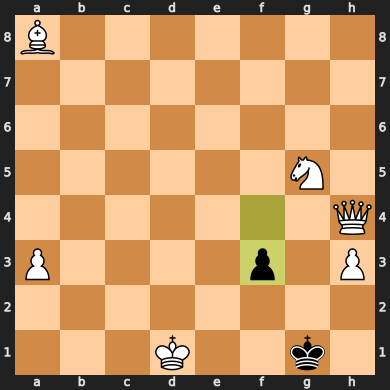

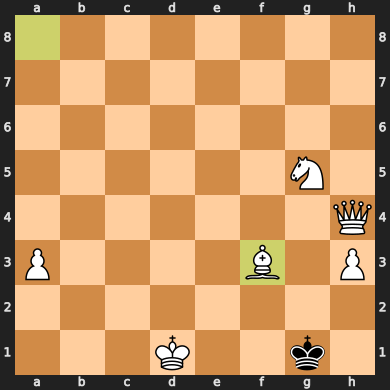

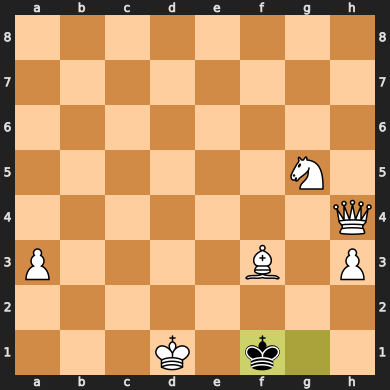

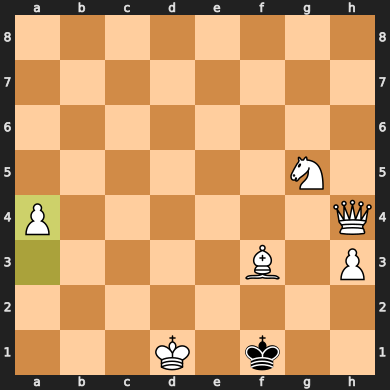

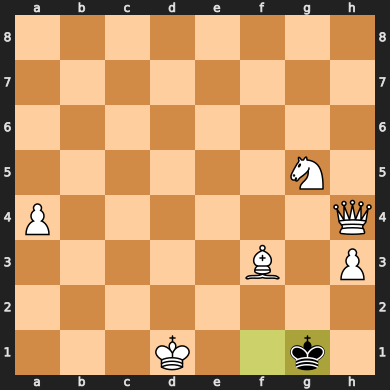

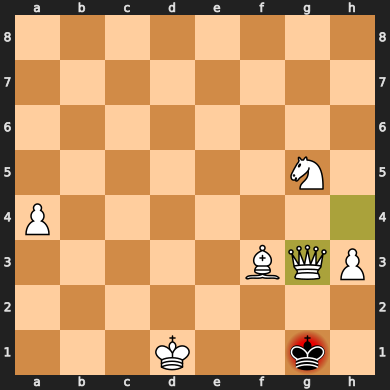

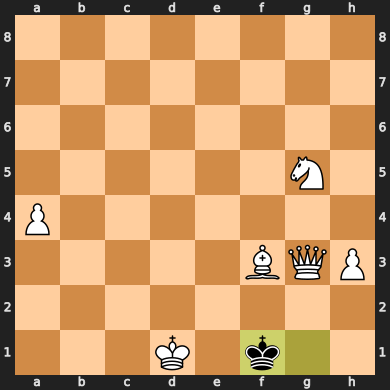

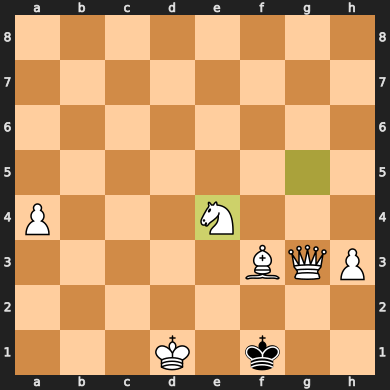

CPU times: user 3min 3s, sys: 443 ms, total: 3min 4s
Wall time: 3min 8s


In [ ]:
%%time
board = chess.Board()
finish = False
count=1
while finish is not True:

      if count==1:
        board.push(random.choice(find_best_moves(board, n_best_moves=10,depth=3,maximizing_player=True)))

      if count==-1:
        board.push(random.choice(find_best_moves(board, n_best_moves=10,depth=3,maximizing_player=False)))

      display(board)
      finish = board.is_insufficient_material() | board.is_stalemate()| board.is_checkmate() | board.is_fivefold_repetition() | board.is_seventyfive_moves()
      count = -1*count